In [42]:
import numpy as np
from cs231n import optim
import matplotlib.pyplot as plt

from cs231n.layers import *
from cs231n.rnn_layers import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
def digits(x):
    d = []
    while x!=0:
        n = x%10
        x /= 10
        d.append(n)
    return list(reversed(d))

def one_hot(x, digit_dim=11):
    z = np.zeros(digit_dim)
    z[x] = 1
    return z

def sample_seq(x, T):
    d = []
    for i in range(T):
        d.extend(digits(x+i))
        d.append(10)
    return d

def one_hot_seq(d, digit_dim):
    # return z of shape (1,d_len,digit_dim)
    d_len = len(d)
    z = np.zeros((d_len,digit_dim))
    z[np.arange(d_len),np.array(d)] = 1
    return np.array([z])

def one_hot_vector(x, digit_dim):
    z = np.zeros((1,digit_dim))
    z[0,x] = 1
    return np.array(z)

def digits_to_no(l):
    a = 0
    d = []
    for i in l:
        if i == 10:
            d.append(a)
            a = 0
        else:
            a *= 10
            a += i
    return d

def sample_data(data):
    l = len(data)
    i = np.random.randint(l)
    return data[i]

In [44]:
class DigitRNN(object):
    def __init__(self, digit_dim=11, hidden_dim=10, cell_type='rnn', dtype=np.float32):
        if cell_type not in {'rnn', 'lstm'}:
            raise ValueError('Invalid cell_type "%s"' % cell_type)

        self.cell_type = cell_type
        self.dtype = dtype
        self.params = {}
        dim_mul = {'lstm': 4, 'rnn': 1}[cell_type]
        self.params['Wx'] = np.random.randn(digit_dim, dim_mul*hidden_dim)/np.sqrt(digit_dim)
        self.params['Wh'] = np.random.randn(hidden_dim, dim_mul*hidden_dim)/np.sqrt(hidden_dim)
        self.params['b'] = np.random.randn(dim_mul*hidden_dim)
        
        self.params['W_digit'] = np.random.randn(hidden_dim, digit_dim)/np.sqrt(hidden_dim)
        self.params['b_digit'] = np.random.randn(digit_dim)
        
        for k, v in self.params.iteritems():
            self.params[k] = v.astype(self.dtype)
    
    def loss(self, seq):
        Wx, Wh, b = self.params['Wx'], self.params['Wh'], self.params['b']
        W_digit, b_digit = self.params['W_digit'], self.params['b_digit']
        
        loss, grads = 0.0, {}
        D = Wx.shape[0]
        H = Wh.shape[0]
        T = len(seq)
        
        h0 = np.zeros((1,H))
        x = one_hot_seq(seq[:-1],digit_dim=D)
        if self.cell_type == 'rnn':
            h, h_cache = rnn_forward(x, h0, Wx, Wh, b)
        elif self.cell_type == 'lstm':
            h, h_cache = lstm_forward(x, h0, Wx, Wh, b)
        scores, af_cache = temporal_affine_forward(h, W_digit, b_digit)
        loss, da = temporal_softmax_loss(scores, np.array([seq[1:]]), np.ones((1,T-1)))
        dh, grads['W_digit'], grads['b_digit'] = temporal_affine_backward(da, af_cache)
        if self.cell_type == 'rnn':
            dx, dh0, grads['Wx'], grads['Wh'], grads['b'] = rnn_backward(dh, h_cache)
        elif self.cell_type == 'lstm':
            dx, dh0, grads['Wx'], grads['Wh'], grads['b'] = lstm_backward(dh, h_cache)
        
        return loss, grads
    
    def sample(self, a, max_length=30, init_length=1):
        Wx, Wh, b = self.params['Wx'], self.params['Wh'], self.params['b']
        W_digit, b_digit = self.params['W_digit'], self.params['b_digit']
        
        D = Wx.shape[0]
        H = Wh.shape[0]
        h0 = np.zeros((1,H))
        
        seq = []
        next_h = h0
        
        x = one_hot_seq(sample_seq(a, init_length), D)
        if self.cell_type == 'rnn':
            h, h_cache = rnn_forward(x, h0, Wx, Wh, b)
        elif self.cell_type == 'lstm':
            h, h_cache = lstm_forward(x, h0, Wx, Wh, b)
        scores, af_cache = temporal_affine_forward(h, W_digit, b_digit)
        id = np.argmax(scores[:,-1], axis=1)
        seq.append(id[0])
        x = one_hot_vector(id[0], digit_dim=D)
        next_h = h[:,-1]
        
        if self.cell_type == 'lstm':
            next_c = h_cache[len(h_cache)-1][-1]
        
        for t in range(max_length):
            if self.cell_type == 'rnn':
                next_h, cache = rnn_step_forward(x, next_h, Wx, Wh, b)
            elif self.cell_type == 'lstm':
                next_h, next_c, cache = lstm_step_forward(x, next_h, next_c, Wx, Wh, b)
            scores = next_h.dot(W_digit) + b_digit
            id = np.argmax(scores, axis=1)
            seq.append(id[0])
            x = one_hot_vector(id[0], digit_dim=D)
        return seq

In [45]:
class DigitSolver(object):
    
    def __init__(self, data, model, **kwargs):
    
        self.model = model
        self.data = data
        
        # Unpack keyword arguments
        self.update_rule = kwargs.pop('update_rule', 'sgd')
        self.optim_config = kwargs.pop('optim_config', {})
        self.lr_decay = kwargs.pop('lr_decay', 0.95)
        self.num_seq = kwargs.pop('num_seq', 100)
        self.print_every = kwargs.pop('print_every', 10)
        self.verbose = kwargs.pop('verbose', True)
        self.num_epochs = kwargs.pop('num_epochs', 10)
        
        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ', '.join('"%s"' % k for k in kwargs.keys())
            raise ValueError('Unrecognized arguments %s' % extra)

        # Make sure the update rule exists, then replace the string
        # name with the actual function
        if not hasattr(optim, self.update_rule):
            raise ValueError('Invalid update_rule "%s"' % self.update_rule)
        self.update_rule = getattr(optim, self.update_rule)

        self._reset()


    def _reset(self):
        """
        Set up some book-keeping variables for optimization. Don't call this
        manually.
        """
        # Set up some variables for book-keeping
        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.iteritems()}
            self.optim_configs[p] = d

    def _step(self):
        """
        Make a single gradient update. This is called by train() and should not
        be called manually.
        """
        seq = sample_data(self.data)
        
        # Compute loss and gradient
        loss, grads = self.model.loss(seq)
        self.loss_history.append(loss)

        # Perform a parameter update
        for p, w in self.model.params.iteritems():
            dw = grads[p]
            config = self.optim_configs[p]
            next_w, next_config = self.update_rule(w, dw, config)
            self.model.params[p] = next_w
            self.optim_configs[p] = next_config

    def train(self):
        """
        Run optimization to train the model.
        """
        N = self.num_seq
        for e in xrange(self.num_epochs):
            for t in xrange(self.num_seq):
                self._step()

            # Maybe print training loss
            if self.verbose:
                print '(Epoch %d / %d) loss: %f' % (
                   e + 1, self.num_epochs, self.loss_history[-1])

            self.epoch += 1
            for k in self.optim_configs:
                self.optim_configs[k]['learning_rate'] *= self.lr_decay


In [37]:
small_data = []
a = [10*i + 1 for i in range(1)]
a = [1]
for i in range(len(a)):
    small_data.append(sample_seq(a[i], 1000))
print len(small_data[0])

3893


In [47]:
big_data = []
a = np.random.randint(1, 15, size=100)
b = np.random.randint(10, 150, size=100)
c = np.random.randint(100, 1200, size=100)
d = np.random.randint(1000, 11000, size=100)
for i in (np.concatenate([a,b,c,d])):
    big_data.append(sample_seq(i, 10))

In [52]:
digit_rnn_model = DigitRNN(
            digit_dim = 11,
            hidden_dim = 250,
            cell_type = 'lstm'
        )

(Epoch 1 / 100) loss: 39.900734
(Epoch 2 / 100) loss: 8.302726
(Epoch 3 / 100) loss: 65.087567
(Epoch 4 / 100) loss: 46.622908
(Epoch 5 / 100) loss: 8.076357
(Epoch 6 / 100) loss: 30.933486
(Epoch 7 / 100) loss: 90.667958
(Epoch 8 / 100) loss: 14.267127
(Epoch 9 / 100) loss: 35.465585
(Epoch 10 / 100) loss: 12.676867
(Epoch 11 / 100) loss: 53.423875
(Epoch 12 / 100) loss: 11.322030
(Epoch 13 / 100) loss: 11.052870
(Epoch 14 / 100) loss: 49.120145
(Epoch 15 / 100) loss: 39.839508
(Epoch 16 / 100) loss: 2.743796
(Epoch 17 / 100) loss: 68.273732
(Epoch 18 / 100) loss: 47.870355
(Epoch 19 / 100) loss: 3.112487
(Epoch 20 / 100) loss: 27.517460
(Epoch 21 / 100) loss: 1.982304
(Epoch 22 / 100) loss: 2.466002
(Epoch 23 / 100) loss: 8.709785
(Epoch 24 / 100) loss: 2.892131
(Epoch 25 / 100) loss: 53.340424
(Epoch 26 / 100) loss: 2.745731
(Epoch 27 / 100) loss: 1.494861
(Epoch 28 / 100) loss: 2.626848
(Epoch 29 / 100) loss: 2.020146
(Epoch 30 / 100) loss: 2.721664
(Epoch 31 / 100) loss: 41.811798

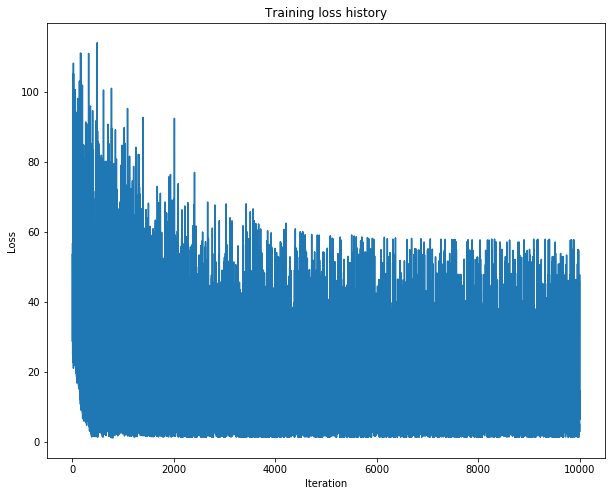

In [57]:
rnn_solver = DigitSolver(big_data, digit_rnn_model,
            update_rule='adam',
            num_epochs = 100,
            num_seq = 100,
            optim_config={
             'learning_rate': 1e-2,
            },
            lr_decay=0.9,
            verbose=True, print_every=10,
        )

rnn_solver.train()

# Plot the training losses
plt.plot(rnn_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

In [63]:
print digits_to_no(digit_rnn_model.sample(2012, max_length=30, init_length=1))

[2013, 2102, 2113, 2112, 1213, 1244]


In [ ]:
Training only on 1-10

digit_dim = 11,
hidden_dim = 1000
update_rule='adam',
num_epochs = 1,
num_seq = 100,
optim_config={
 'learning_rate': 1e-2,
},
lr_decay=0.95,
verbose=True, print_every=10,
--> [2, 3, 4, 5, 6, 7, 87999, 66708, 9]

changed the weight init
digit_dim = 11,
hidden_dim = 100
update_rule='adam',
num_epochs = 1,
num_seq = 100,
optim_config={
 'learning_rate': 1e-2,
},
lr_decay=0.95,
verbose=True, print_every=10,
--> [2, 3, 4, 5, 6, 7, 8, 9, 2, 5, 9, 2, 3, 4, 5]